# Mathematics for signal processing notebook
Guillaume TOCHON (<guillaume.tochon@lrde.epita.fr>) & Ã‰lodie PUYBAREAU (<elodie@lrde.epita.fr>)

In [1]:
# Import all custom-made functions
import MASI
import ECG
# Import all the usual stuff
import numpy as np
pi = np.pi # coz' I'm lazy af
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
# Matplotlib in inline mode
%matplotlib inline
# Shut warnings off (I'm a terrible person)
import warnings
warnings.filterwarnings('ignore')

## Fourier transform

<img src="https://www.explainxkcd.com/wiki/images/f/f0/fourier.jpg" width="400">

### What's wrong with Fourier series decomposition ?

We have seen that Fourier serie decomposition applies to periodic signals only. This actually originated from the superposition principle : a complicated but periodic signal can be decomposed as a combination of much simpler (and still periodic) signals.  

But what's up with **real** signals (_i.e._, coming from the real world) ? Is a signal really periodic when it's expected to be ?

In [12]:
from scipy.io import wavfile
(fs,wav) = sp.io.wavfile.read('Alesis-Fusion-Bright-Acoustic-Piano-C2.wav')
wav = wav[:,0]/wav[:,0].max()

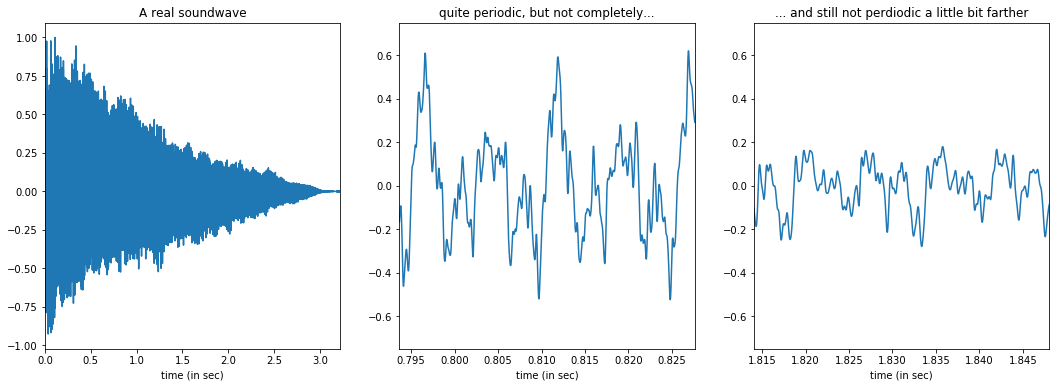

In [13]:
t_wav = np.arange(0,wav.size)/fs
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('A real soundwave')
plt.plot(t_wav,wav)
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.subplot(132)
plt.title('quite periodic, but not completely...')
sub_length = 1500
sub_start = int(3.5e4)
plt.plot(t_wav[sub_start:sub_start+sub_length],wav[sub_start:sub_start+sub_length])
plt.xlim((t_wav[sub_start],t_wav[sub_start+sub_length-1]))
plt.xlabel('time (in sec)')
plt.ylim((-0.75,0.75))
plt.subplot(133)
plt.title('... and still not perdiodic a little bit farther')
sub_length = 1500
sub_start = int(8e4)
plt.plot(t_wav[sub_start:sub_start+sub_length],wav[sub_start:sub_start+sub_length])
plt.xlim((t_wav[sub_start],t_wav[sub_start+sub_length-1]))
plt.xlabel('time (in sec)')
plt.ylim((-0.75,0.75))
plt.show()

So, let's say that we want to check whether the piano that played this note is well tuned up. It means that we somehow have to compute the fundamental frequency of this soundwave (and the first few harmonics if we also want to check the tone color). But is the Fourier series decomposition really the most suited tool here ?
- It works in a theoretical set-up with periodic signals only.
- Even disregarding the fact that our sound here is not stricly periodic, it is gonna be tricky to apply it from a computational point of view. We need to extract exactly one period out of the full signal:
    - how to select the starting point and the endpoint ? 
    - in which part of the whole signal ?  
    
Let's look for a more adapted tool.

### Going from Fourier series to the Fourier transform

In [2]:
# define time vector
Tech = 0.001 # sampling period
t_min = 0
t_max = 10
t = np.arange(t_min,t_max+Tech,Tech) # time vector between t_min and t_max

In [15]:
# define function on one period
x_T = lambda t_T,T: np.sqrt(np.abs(t_T)/T)

The gap between two consecutive harmonics $c_n$ and $c_{n+1}$ of a $T-$periodic signal is $\displaystyle\frac{1}{T}$ (since $c_n$ and $c_{n+1}$ are associated with frequencies $\displaystyle\frac{n}{T}$ and $\displaystyle\frac{n+1}{T}$ respectively). So, the larger $T$, the smaller the gap between two consecutives harmonics, and this gaps goes to $0$ as $T \rightarrow +\infty$.

In [16]:
MASI.visualize_series2transform(x_T,t,t_max,Tech)

A non-periodic signal $x$ can be thought of as a periodic signal with infinite period. Following this idea, the gap between two consecutive harmonics of a non-periodic signal is 0, hence its spectrum is continuous : that's the Fourier transform.  

If $x \in \mathcal{L}^1(\mathbb{R})$ (sufficient condition for it to possess a Fourier transform), then its Fourier transform is the real-valued, complex function $X : \mathbb{R} \rightarrow \mathbb{C}$ defined by
$$ \displaystyle X : \nu \mapsto X(\nu) = \int_{-\infty}^{+ \infty} x(t) e^{-i2\pi\nu t }dt$$

In [2]:
Tech = 0.01
Tmax = 31
T = np.arange(1,Tmax+1,2)
t = np.arange(-np.floor(Tmax/2),np.floor(Tmax/2),Tech)
nu = (np.arange(0,t.size)/t.size-1/2)/Tech

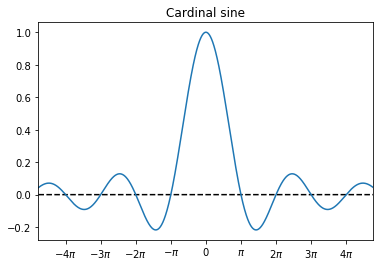

In [4]:
# Let's plot a cardinal sine real quick here
sinc = np.sin(t)/(t)
plt.title('Cardinal sine')
plt.plot(t,np.zeros(t.size),'--k')
plt.plot(t,sinc)
plt.xlim(t.min(),t.max())
xtik = [n*np.pi for n in range(-4,5)]
xtiklbl = []
for n in range(-4,5):
    if n == 0:
        xtiklbl.append('0')
    elif n == 1:
        xtiklbl.append(r'$\pi$')
    elif n == -1:
        xtiklbl.append(r'$-\pi$')
    else:
        xtiklbl.append(r'$%d\pi$'%n)
plt.xticks(xtik,xtiklbl)
plt.show()

In [5]:
MASI.visualize_squarewindowFT(t,Tech,nu)

A few words about the spectrum $|\hat{\Pi}_T(\nu)|$ displayed above... Theoretically, the Fourier fransform of a real and even function is also a real and even function. So why do we have to plot $|\hat{\Pi}_T|$ and not $\hat{\Pi}_T$ directly?  
Although the square window function on the above left looks even, it is **not** for Python : it is an array of size $N$ filled with 0's and 1's (no surprise here). But the array indices range from 0 to $N-1$, not from $\displaystyle-\frac{N}{2}$ to $\displaystyle\frac{N-1}{2}$. So, we can manage to make it look even when we plot it, but when we call the Fourier transform function over it, it is not seen as even, hence a Fourier transform that is complex and not real, thus the necessity to plot the modulus.

### A little story of Dirac impulses

Since we have introduced the Dirac as the Fourier transform of a plain constant signal, let's dig a tad further into the properties of this little guy.

In [6]:
x = sp.signal.gausspulse(t/t.size)
MASI.visualize_Dirac(x,t,Tech)

### Classical Fourier transforms

In [29]:
# A few signals for which we can plot the Fourier transform
# -------------------------------
# comment/uncomment proper line

# cosine wave
T=3 # so fundamental frequency is 1/T
# fmax = 1.2/T
# p = True
# x = np.cos(2*np.pi/T*(t-t.min()))
# title_wave = 'cosine wave with fundamental frequency %1.2f Hz'%(1/T)

# sine wave
# T=5 # so fundamental frequency is 1/T
# fmax = 1.2/T
# p = True
# x = np.sin(2*np.pi/T*t)
# title_wave = 'sin wave with fundamental frequency %1.2f Hz'%(1/T)

# gaussian pulse
# k = 0.5
# fmax = 1.2*k
# p = False
# x = sp.signal.gausspulse((k*t)/t.size)
# title_wave = 'Gaussian pulse'

# chirp
# f_min = 0.1
# f_max = 0.5
# fmax = 4*f_max
# p = False
# x = sp.signal.chirp(t,f_max,t.max(),f_min)
# title_wave = 'chirp with frequency going from %1.2f Hz to %1.2f'%(f_min,f_max)

# gaussian
sigma = 1
fmax = 1.2/(sigma)
p = False
x = sp.stats.norm.pdf(t,scale=sigma)
title_wave = r'Gaussian wave with standard deviation $\sigma=$%1.2f'%(sigma)

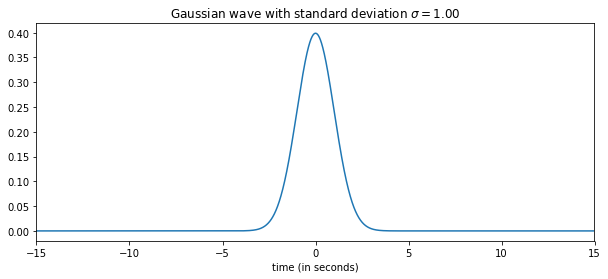

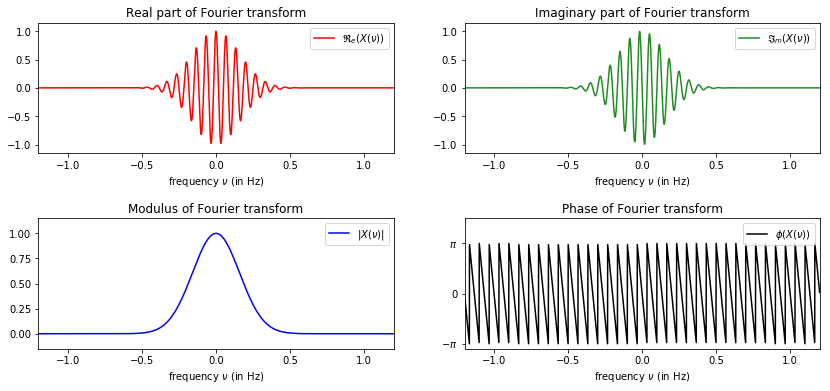

In [30]:
plt.figure(figsize=(10,4))
plt.plot(t,x)
plt.xlim(t.min(),t.max())
plt.xlabel('time (in seconds)')
plt.title(title_wave)
# --------------------------
MASI.plotFourierTransform(x,t,Tech,f_max=fmax,interp=p)

There are three observations you may want to retain from the previous examples:
- $\displaystyle \mathcal{F}\left(\cos(2\pi\nu_0 t)\right) = \frac{1}{2}\left(\delta(\nu+\nu_0)+\delta(\nu-\nu_0) \right) $ $\rightarrow$ the cosine of fundamental frequency $\nu_0$ has two Diracs centered on $-\nu_0$ and $\nu_0$ as Fourier transform. As $t \mapsto \cos(2\pi\nu_0 t)$ is real and even, so is its Fourier transform.
- $\displaystyle \mathcal{F}\left(\sin(2\pi\nu_0 t)\right) = \frac{i}{2}\left(\delta(\nu+\nu_0)-\delta(\nu-\nu_0) \right) $ $\rightarrow$ the sine of fundamental frequency $\nu_0$ has two Diracs centered on $-\nu_0$ (positive) and $\nu_0$ (negative) as Fourier transform. As $t \mapsto \cos(2\pi\nu_0 t)$ is real and odd, its Fourier transform is imaginary and odd.
- The Gaussian function $e^{-\alpha t^2}$ is mapped to itself (up to some scaling coefficient) through the Fourier transform (this is actually the starting point of the proof of Heisenberg inequality...). Again, as the Gaussian function is real and even, so is its Fourier transform.

### Influence of the phase  

Let's:  
1. define two different signals,
2. take their Fourier transform,
3. mix each modulus with the phase of the other,
4. invert the resulting chimeric Fourier transform,
5. ...
6. profit

In [41]:
# 1 -------
x1 = sp.signal.chirp(t,0.5,t.max(),0.1)
# x1 = sp.signal.gausspulse((0.5*t)/t.size)
x2 = np.exp(-np.abs(t)/0.5)
# 2 -------
X1 = sp.fftpack.fftshift(sp.fftpack.fft(x1))
X2 = sp.fftpack.fftshift(sp.fftpack.fft(x2))
# 3 -------
X_chimeric1 = np.abs(X1)*np.exp(1j*np.angle(X2))
X_chimeric2 = np.abs(X2)*np.exp(1j*np.angle(X1))
# 4 -------
# modulus to remove super low imaginary part
x_chimeric1 = np.real(sp.fftpack.ifft(sp.fftpack.ifftshift(X_chimeric1)))
x_chimeric2 = np.real(sp.fftpack.ifft(sp.fftpack.ifftshift(X_chimeric2)))

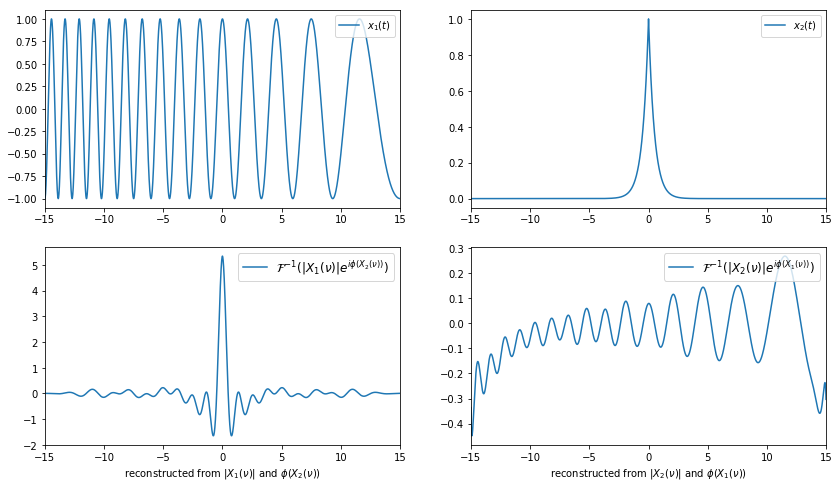

In [42]:
plt.figure(figsize=(14,8))
plt.subplot(221)
plt.plot(t,x1,label=r'$x_1(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right')
plt.subplot(222)
plt.plot(t,x2,label=r'$x_2(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right')
plt.subplot(223)
leg1 = r'$\mathcal{F}^{-1}(|X_1(\nu)|e^{i\phi(X_2(\nu))})$'
plt.plot(t,x_chimeric1,label=leg1)
plt.xlim(t.min(),t.max())
plt.xlabel(r'reconstructed from $|X_1(\nu)|$ and $\phi(X_2(\nu))$')
plt.legend(loc='upper right',fontsize=12)
plt.subplot(224)
leg2 = r'$\mathcal{F}^{-1}(|X_2(\nu)|e^{i\phi(X_1(\nu))})$'
plt.plot(t,x_chimeric2,label=leg2)
plt.xlim(t.min(),t.max())
plt.xlabel(r'reconstructed from $|X_2(\nu)|$ and $\phi(X_1(\nu))$')
plt.legend(loc='upper right',fontsize=12)
plt.show()

### Plancheral theorem  

Plancherel theorem states that the convolution product is mapped to an algebraic product through the Fourier transform, _i.e._  
$$\mathcal{F}(x_1 \ast x_2) = X_1(\nu)\times X_2(\nu).$$
Let's check that $x_1 \ast x_2 = \mathcal{F}^{-1}\left(X_1(\nu) X_2(\nu) \right)$.

In [43]:
x1 = sp.signal.chirp(t,0.5,t.max(),0.1)
x2 = np.exp(-np.abs(t)/0.5)
# --- Convolution by direct method ---
xconv = Tech*sp.signal.convolve(x1,x2,mode='full',method='direct')
t_conv = np.arange(2*t.min(),2*(t.max())+Tech,Tech)
# --- Convolution by Fourier trasnform ---
X1 = sp.fftpack.fft(x1,xconv.size)
X2 = sp.fftpack.fft(x2,xconv.size)
Xconv = X1*X2
xconv_Fourier = np.real(sp.fftpack.ifft(Tech*Xconv))

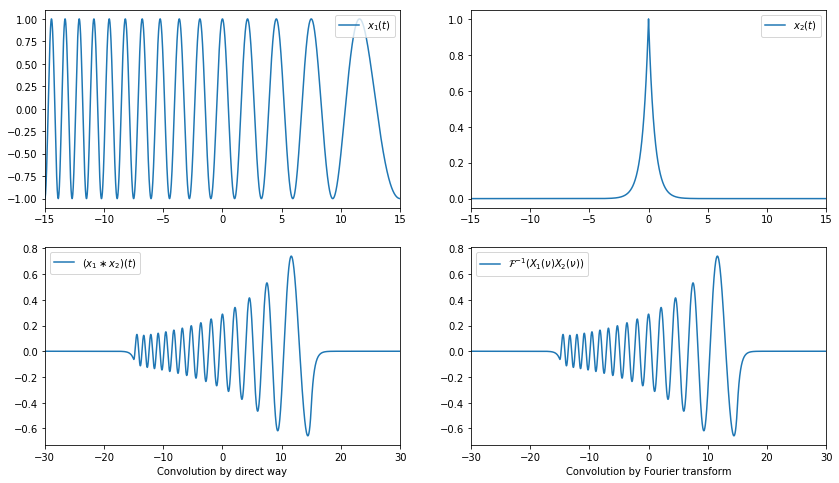

In [45]:
plt.figure(figsize=(14,8))
plt.subplot(221)
plt.plot(t,x1,label=r'$x_1(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right')
plt.subplot(222)
plt.plot(t,x2,label=r'$x_2(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right')
plt.subplot(223)
plt.plot(t_conv,xconv,label=r'$(x_1 \ast x_2)(t)$')
plt.xlim(t_conv.min(),t_conv.max())
plt.xlabel('Convolution by direct way')
plt.legend(loc='upper left')
plt.subplot(224)
plt.plot(t_conv,xconv_Fourier,label=r'$\mathcal{F}^{-1}(X_1(\nu)X_2(\nu))$')
plt.xlim(t_conv.min(),t_conv.max())
plt.xlabel('Convolution by Fourier transform')
plt.legend(loc='upper left')
plt.show()

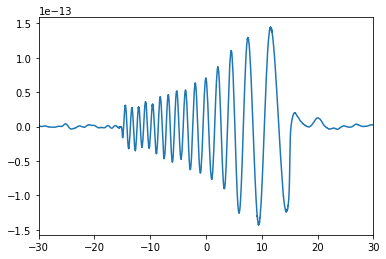

In [46]:
# And just to be sure, let's plot the difference
plt.plot(t_conv,xconv-xconv_Fourier)
plt.xlim(t_conv.min(),t_conv.max())
plt.show()

We can forgive a $1e-13$ magnitude error... All good, Plancherel theorem is verified.

### Parseval equality

Let's now check Parseval theorem.  
For Fourier series, Parseval equality stated that the energy of a perdiodic signal over a period was equal to the sum of the energies of all harmonics: $\displaystyle \frac{1}{T} \int_0^T |x(t)|^2 dt = \sum_{n \in \mathbb{Z}} |c_n|^2$  
For the Fourier transform, Parseval equality is a little bit more general, as it states that $\displaystyle \int_\mathbb{R} x_1(t)\overline{x_2(t)} dt = \int_\mathbb{R} X_1(\nu)\overline{X_2(\nu)} d\nu$. However, taking $x_2 \equiv x_1$ yields $\displaystyle \int_\mathbb{R} |x_1(t)|^2 dt = \int_\mathbb{R} |X_1(\nu)|^2 d\nu$, whose interpretation is the exact same as the equality for Fourier series: the signal energy is preserved in the frequency domain. Temporal and frequency representations are two different point of views to express the same information.

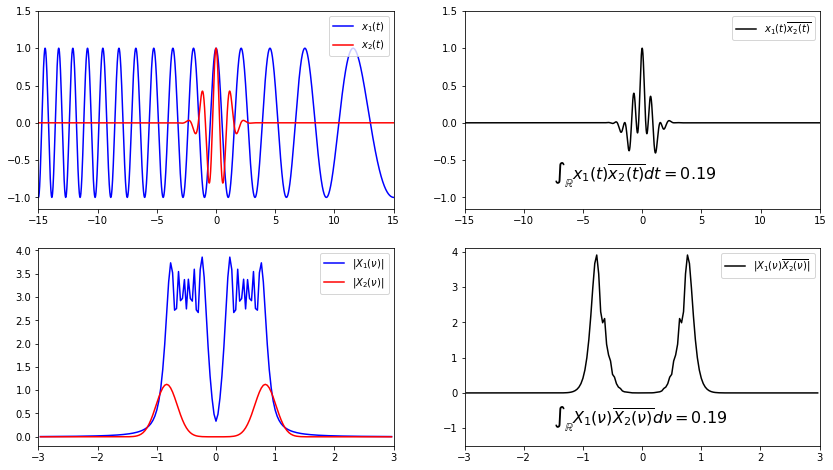

In [47]:
# Never change a winning team: let's take the same signals again
x1 = sp.signal.chirp(t,0.5,t.max(),0.1)
X1 = sp.fftpack.fftshift(sp.fftpack.fft(x1))*Tech
x2 = sp.signal.gausspulse(2.5*t/t.size)
X2 = sp.fftpack.fftshift(sp.fftpack.fft(x2))*Tech

# Product in the temporal domain
xprod = x1*np.conj(x2) # product of x1 and conj(x2)
Eprod_temp = xprod.sum()*Tech # energy of xprod

# Now in the frquency domain
Xprod = X1*np.conj(X2) # product of X1 and conj(X2)
nuech = (nu.max()-nu.min())/nu.size # retrieve frquency sampling rate
Eprod_freq = Xprod.sum()*nuech # energy of Xprod


# ---- Plot that stuff ----
plt.figure(figsize=(14,8))
plt.subplot(221)
plt.plot(t,x1,'b',label=r'$x_1(t)$')
plt.plot(t,x2,'r',label=r'$x_2(t)$')
plt.xlim(t.min(),t.max())
plt.ylim(-1.15,1.5)
plt.legend(loc='upper right')
plt.subplot(222)
plt.plot(t,x1*np.conj(x2),'k',label=r'$x_1(t) \overline{x_2(t)}$')
plt.xlim(t.min(),t.max())
plt.ylim(-1.15,1.5)
plt.text(-7.5,-0.75,r'$\int_\mathbb{R} x_1(t)\overline{x_2(t)}dt = %2.2f$'%Eprod_temp,fontsize=16)
plt.legend(loc='upper right')
plt.subplot(223)
plt.plot(nu[np.abs(nu)<3],np.abs(X1[np.abs(nu)<3]),'b',label=r'$|X_1(\nu)|$')
plt.plot(nu[np.abs(nu)<3],np.abs(X2[np.abs(nu)<3]),'r',label=r'$|X_2(\nu)|$')
plt.xlim(-3,3)
# plt.ylim(-1.15,1.5)
plt.legend(loc='upper right')
plt.subplot(224)
plt.plot(nu[np.abs(nu)<3],np.abs(X1[np.abs(nu)<3]*np.conj(X2[np.abs(nu)<3])),'k',label=r'$|X_1(\nu)\overline{X_2(\nu)}|$')
plt.xlim(-3,3)
plt.ylim(ymin=-1.5)
plt.text(-1.5,-0.85,r'$\int_\mathbb{R} X_1(\nu)\overline{X_2(\nu)}d\nu = %2.2f$'%Eprod_freq,fontsize=16)
plt.legend(loc='upper right')
plt.show()

### Energy spectral density

Parseval equality stated that the energy of the signal $E_x = \displaystyle \int_\mathbb{R} |x(t)|^2 dt$ is preserved when computed in the Fourier domain, _i.e._, $E_x = \displaystyle \int_\mathbb{R} |X(\nu)|^2 d\nu$.  
The quantity $|X(\nu)|^2$ is called the energy spectral density, it plays the same role in the frequency domain as $|x(t)|^2$ in the temporal domain (which can be understood as some kind of instantaneous energy).  
Besides, it is possible to show that the Fourier transform of the autocorrelation function $\Gamma_{xx}$ is precisely the energy spectral density (that is a direct application of Plancherel theorem)
$$\mathcal{F}\left( \Gamma_{xx}\right) = \gamma_{xx}(\nu) = |X(\nu)|^2$$
The exact same relation holds for the Fourier transform of the cross-correlation between two signals $x$ and $y$, that is
$$\mathcal{F}\left( \Gamma_{xy}\right) = \gamma_{xy}(\nu) = X(\nu)\overline{Y(\nu)}$$
where $\gamma_{xy}$ is called the cross-spectral density.  

Let's illustrate all of this.

In [29]:
# First on some dummy signals
# comment/uncomment proper line

k = 2
x = sp.signal.gausspulse(k*t/t.size)
numax = k

# x = np.exp(-np.abs(t)/0.5)
# numax = 2

Gamma_xx = Tech*sp.signal.correlate(x,x,method='direct')
gamma_xx = sp.fftpack.fftshift(sp.fftpack.fft(Gamma_xx))*Tech
X = sp.fftpack.fftshift(sp.fftpack.fft(x,Gamma_xx.size))*Tech
nu = sp.fftpack.fftshift(sp.fftpack.fftfreq(X.size))/Tech

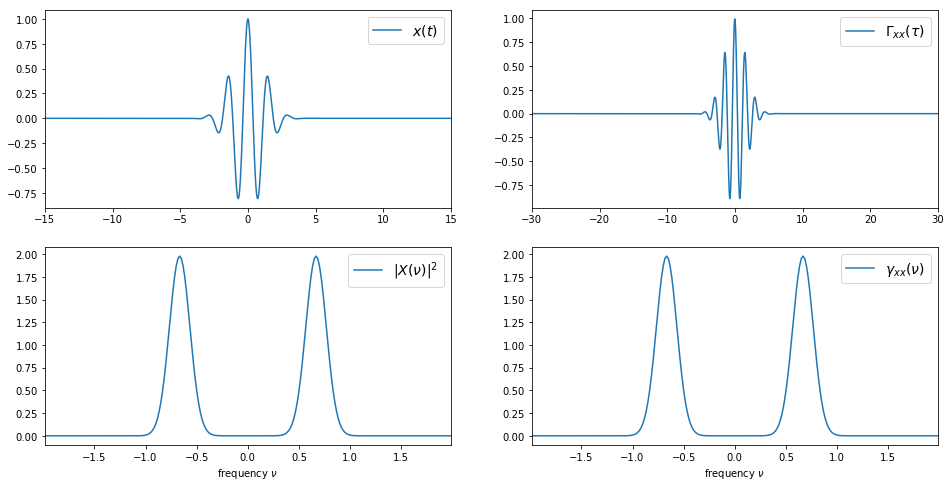

In [30]:
t_corr = np.arange(2*t.min(),2*t.max()+Tech,Tech)

# Plot all that stuff
plt.figure(figsize=(16,8))
plt.subplot(221)
plt.plot(t,x,label=r'$x(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right',fontsize=14)
plt.subplot(222)
plt.plot(t_corr,Gamma_xx,label=r'$\Gamma_{xx}(\tau)$')
plt.xlim(t_corr.min(),t_corr.max())
plt.legend(loc='upper right',fontsize=14)
plt.subplot(223)
plt.plot(nu[np.abs(nu)<numax],np.abs(X[np.abs(nu)<numax])**2,label=r'$|X(\nu)|^2$')
plt.xlim(nu[np.abs(nu)<numax].min(),nu[np.abs(nu)<numax].max())
plt.xlabel(r'frequency $\nu$')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(224)
plt.plot(nu[np.abs(nu)<numax],np.abs(gamma_xx[np.abs(nu)<numax]),label=r'$\gamma_{xx}(\nu)$')
plt.xlim(nu[np.abs(nu)<numax].min(),nu[np.abs(nu)<numax].max())
plt.xlabel(r'frequency $\nu$')
plt.legend(loc='upper right',fontsize=14)
plt.show()

OK, $\gamma_{xx}(\nu) = |X(\nu)|^2$ computed first as $|\mathcal{F}(x)|^2$ and second, directly as $\mathcal{F}(\Gamma_{xx})$ well look alike above. And their difference (below) confirms that.

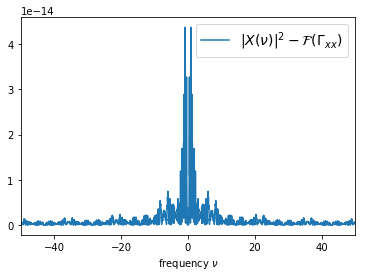

In [31]:
plt.plot(nu,np.abs(np.abs(X)**2-np.abs(gamma_xx)),label=r'$|X(\nu)|^2 - \mathcal{F}(\Gamma_{xx})$')
plt.xlim(nu.min(),nu.max())
plt.xlabel(r'frequency $\nu$')
plt.legend(loc='upper right',fontsize=14)
plt.show()

We can also check that the cross-spectral density $\gamma_{xy}$ can be obtained either as the Fourier transform of the cross-correlation $\Gamma_{xy}$ of $x$ and $y$, or by $X(\nu)\overline{Y(\nu)}$

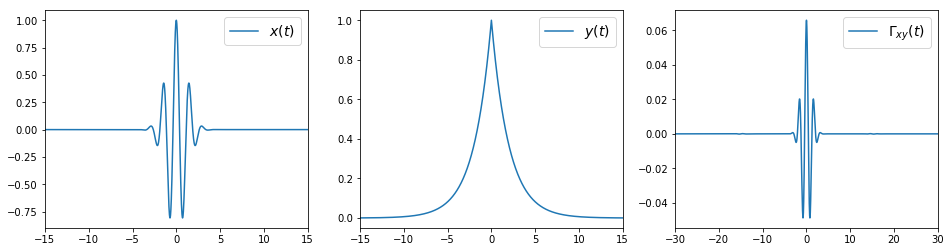

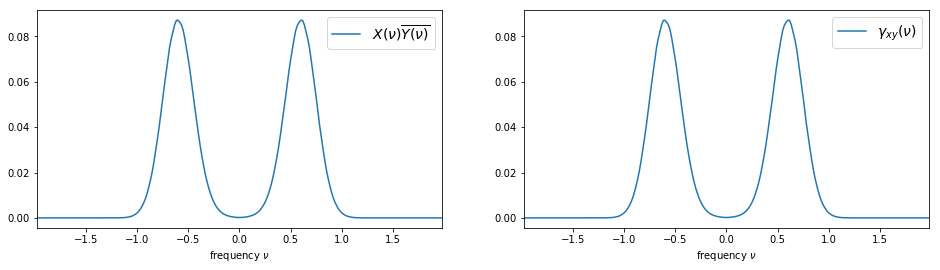

In [32]:
# Let's take the two signals of the cell above (yeah, I'm lazy)
x = sp.signal.gausspulse(2*t/t.size)
y = np.exp(-np.abs(t)/2)
Gamma_xy = Tech*sp.signal.correlate(x,y,method='direct')
numax = 2

# In the Fourier domain again
X = sp.fftpack.fftshift(sp.fftpack.fft(x,Gamma_xy.size))*Tech
Y = sp.fftpack.fftshift(sp.fftpack.fft(y,Gamma_xy.size))*Tech
XY = np.multiply(X,np.conj(Y))
gamma_xy = sp.fftpack.fftshift(sp.fftpack.fft(Gamma_xy))*Tech

# And here comes the plot
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(t,x,label=r'$x(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right',fontsize=14)
plt.subplot(132)
plt.plot(t,y,label=r'$y(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='upper right',fontsize=14)
plt.subplot(133)
plt.plot(t_corr,Gamma_xy,label=r'$\Gamma_{xy}(t)$')
plt.xlim(t_corr.min(),t_corr.max())
plt.legend(loc='upper right',fontsize=14)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(nu[np.abs(nu)<numax],np.abs(XY[np.abs(nu)<numax]),label=r'$X(\nu)\overline{Y(\nu)}$')
plt.xlim(nu[np.abs(nu)<numax].min(),nu[np.abs(nu)<numax].max())
plt.xlabel(r'frequency $\nu$')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(122)
plt.plot(nu[np.abs(nu)<numax],np.abs(gamma_xy[np.abs(nu)<numax]),label=r'$\gamma_{xy}(\nu)$')
plt.xlim(nu[np.abs(nu)<numax].min(),nu[np.abs(nu)<numax].max())
plt.xlabel(r'frequency $\nu$')
plt.legend(loc='upper right',fontsize=14)
plt.show()

And again, the two methods for computing $\gamma_{xy}$ seem to give identical results, which is confirmed by the magnitude of the difference below.

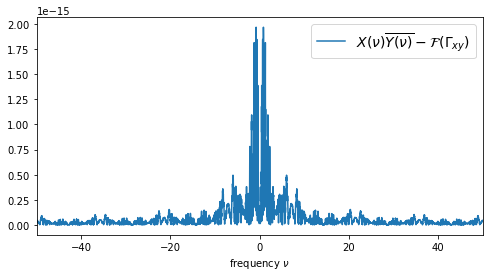

In [33]:
plt.figure(figsize=(8,4))
plt.plot(nu,np.abs(np.abs(XY)-np.abs(gamma_xy)),label=r'$X(\nu)\overline{Y(\nu)} - \mathcal{F}(\Gamma_{xy})$')
plt.xlim(nu.min(),nu.max())
plt.xlabel(r'frequency $\nu$')
plt.legend(loc='upper right',fontsize=14)
plt.show()

### C'mon dude, can we see real signals already ??

OK, OK, chill out, we're getting there...  
Let's get back to the piano soundwave, and see what its Fourier transform looks like

In [3]:
from scipy.io import wavfile
(fs,wav) = sp.io.wavfile.read('Alesis-Fusion-Bright-Acoustic-Piano-C2.wav')
wav = wav[:,0]/wav[:,0].max()

In [4]:
# time vector for soundwave
t_wav = np.arange(0,wav.size)/fs

# Now let's compute the Fourier transform
Wav = sp.fftpack.fftshift(sp.fftpack.fft(wav))/fs
nu = sp.fftpack.fftshift(sp.fftpack.fftfreq(t_wav.size))*fs

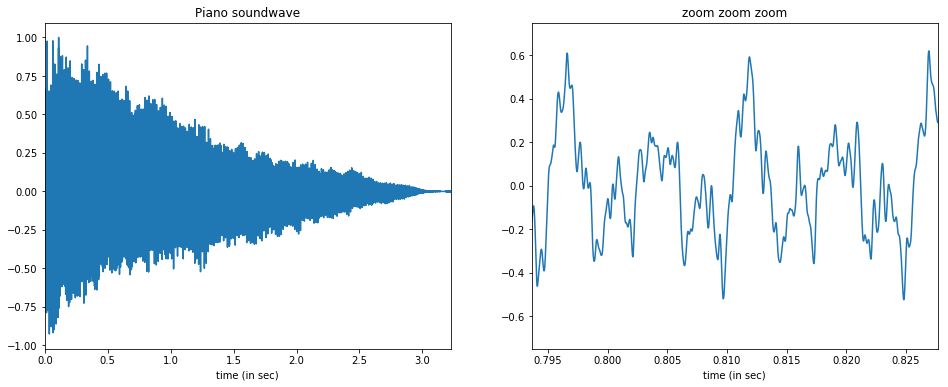

In [5]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Piano soundwave')
plt.plot(t_wav,wav)
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.subplot(122)
plt.title('zoom zoom zoom')
sub_length = 1500
sub_start = int(3.5e4)
plt.plot(t_wav[sub_start:sub_start+sub_length],wav[sub_start:sub_start+sub_length])
plt.xlim((t_wav[sub_start],t_wav[sub_start+sub_length-1]))
plt.xlabel('time (in sec)')
plt.ylim((-0.75,0.75))
plt.show()

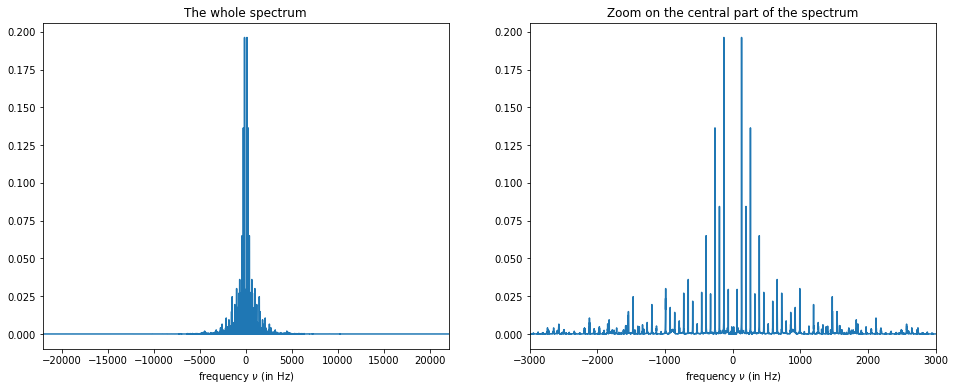

In [21]:
nu_max = 3000
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('The whole spectrum')
plt.plot(nu,np.abs(Wav))
plt.xlim(nu.min(),nu.max())
plt.xlabel(r'frequency $\nu$ (in Hz)')
plt.subplot(122)
plt.title('Zoom on the central part of the spectrum')
plt.plot(nu[np.abs(nu)<nu_max],np.abs(Wav[np.abs(nu)<nu_max]))
plt.xlim(nu[np.abs(nu)<nu_max].min(),nu[np.abs(nu)<nu_max].max())
plt.xlabel(r'frequency $\nu$ (in Hz)')
plt.show()

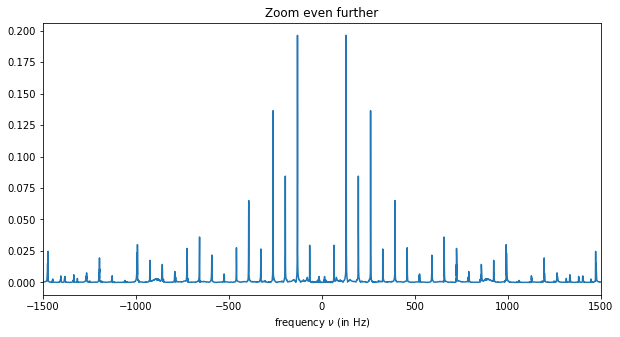

In [8]:
nu_max = 1500
plt.figure(figsize=(10,5))
plt.title('Zoom even further')
plt.plot(nu[np.abs(nu)<nu_max],np.abs(Wav[np.abs(nu)<nu_max]))
plt.xlim(nu[np.abs(nu)<nu_max].min(),nu[np.abs(nu)<nu_max].max())
plt.xlabel(r'frequency $\nu$ (in Hz)')
plt.show()

Let's see if we can retrieve the frequencies of those nice harmonics

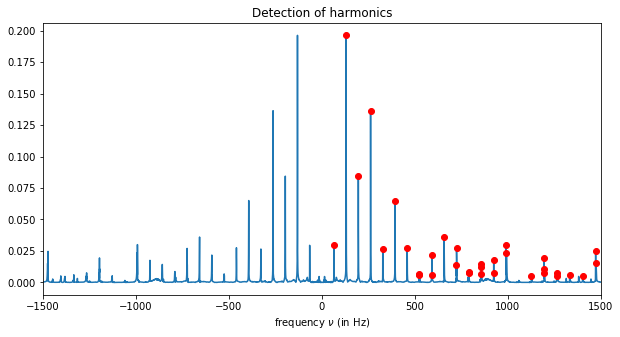

In [9]:
# First let's restrict the search area to frequencies comprised between 0 and  1.5 kHz
nu_idx = (nu>=0)&(nu<nu_max)

# Now let's find the peaks in the spectrum
peaks = sp.signal.find_peaks(np.abs(Wav[nu_idx]),height=0.005)
peaks_pos = peaks[0]
peaks_height = peaks[1]

# Let's check we have detected the correct peaks
plt.figure(figsize=(10,5))
plt.title('Detection of harmonics')
plt.plot(nu[np.abs(nu)<nu_max],np.abs(Wav[np.abs(nu)<nu_max]))
plt.xlim(nu[np.abs(nu)<nu_max].min(),nu[np.abs(nu)<nu_max].max())
plt.plot(nu[nu_idx][peaks_pos],peaks_height['peak_heights'],'ro')
plt.xlabel(r'frequency $\nu$ (in Hz)')
plt.show()

OK, that's not perfect, but it's not that bad considering that we have written a peak selection algorithm that is 3 lines long... Seems that there are a few duplicates, let's filter them out first.

In [10]:
peaks_pos = peaks_pos[np.hstack((True,np.diff(peaks_pos)>10))]

So, what are the corresponding (first few) frequencies?

In [11]:
for n,f in enumerate(nu[nu_idx][peaks_pos]):
    print('Peak #%d is at frequency %1.2f'%(n+1,f))

Peak #1 is at frequency 65.44
Peak #2 is at frequency 130.89
Peak #3 is at frequency 196.33
Peak #4 is at frequency 262.08
Peak #5 is at frequency 327.52
Peak #6 is at frequency 392.97
Peak #7 is at frequency 459.03
Peak #8 is at frequency 524.16
Peak #9 is at frequency 590.53
Peak #10 is at frequency 657.22
Peak #11 is at frequency 723.28
Peak #12 is at frequency 789.96
Peak #13 is at frequency 856.34
Peak #14 is at frequency 923.95
Peak #15 is at frequency 991.26
Peak #16 is at frequency 1126.79
Peak #17 is at frequency 1194.72
Peak #18 is at frequency 1264.50
Peak #19 is at frequency 1333.36
Peak #20 is at frequency 1403.45
Peak #21 is at frequency 1472.00


So, the first peak is a frequency 65.44 Hz, and the following are at frequencies that are multiples of 65.44 Hz.  
Thus, 65.44 Hz is the fundamental frequency of the note, and the following peaks are its harmonics.  
But did we mananged to find the correct frequency?

The note was a C2, and putting A4 at 440 Hz, it turns out that C2 is theoretically at 65.41 Hz, so it's all good!

But wait, if we retrieve the frequency and height of those first few harmonics, we can simulate them to be the first $c_n$ coefficient of a Fourier series decomposition. So, if we invert this Fourier series decomposition, we could re-synthetize a note. Let's see...

In [12]:
# First pu everything in the shape of a Fourier series decomposition
fn = []
cn = []
for n,f in enumerate(nu[nu_idx][peaks_pos]):
    fn.append(f)
    cn.append(Wav[nu_idx][peaks_pos[n]])
    
# Now synthesize the note from fn/cn
wav_synth = np.zeros(t_wav.size,dtype=complex) # let's make it with zero mean
for n,f in enumerate(fn):
    wav_synth += cn[n]*np.exp(1j*2*np.pi*f*t_wav) + np.conj(cn[n])*np.exp(-1j*2*np.pi*f*t_wav)

wav_synth = np.real(wav_synth)

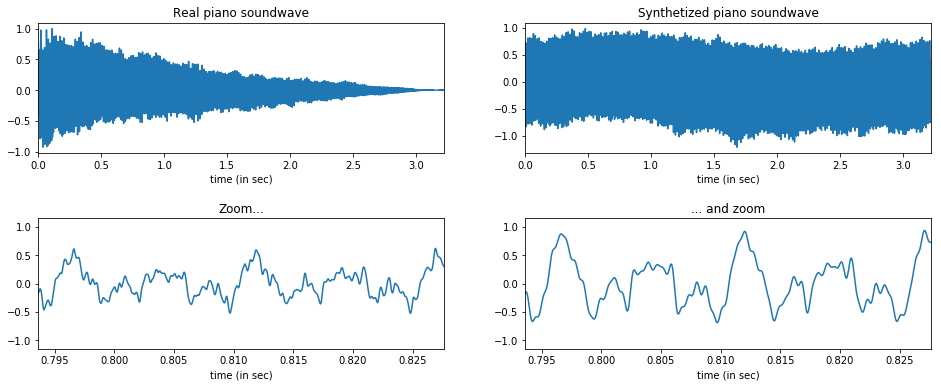

In [13]:
plt.figure(figsize=(16,6))
plt.subplots_adjust(hspace=0.5)
plt.subplot(221)
plt.title('Real piano soundwave')
plt.plot(t_wav,wav)
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.subplot(222)
plt.title('Synthetized piano soundwave')
plt.plot(t_wav,wav_synth)
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.subplot(223)
plt.title('Zoom...')
sub_length = 1500
sub_start = int(3.5e4)
plt.plot(t_wav[sub_start:sub_start+sub_length],wav[sub_start:sub_start+sub_length])
plt.xlim((t_wav[sub_start],t_wav[sub_start+sub_length-1]))
plt.xlabel('time (in sec)')
plt.ylim((-1.15,1.15))
plt.subplot(224)
plt.title('... and zoom')
sub_length = 1500
sub_start = int(3.5e4)
plt.plot(t_wav[sub_start:sub_start+sub_length],wav_synth[sub_start:sub_start+sub_length])
plt.xlim((t_wav[sub_start],t_wav[sub_start+sub_length-1]))
plt.xlabel('time (in sec)')
plt.ylim((-1.15,1.15))
plt.show()

OK, we got a not so bad approximation of the medium/high frequency components since we only retained a few harmonics, but we need to take into account the overall signal envelope (since the signal amplitude decreases with time).  
We can approximate this envelope by a decreasing exponential.

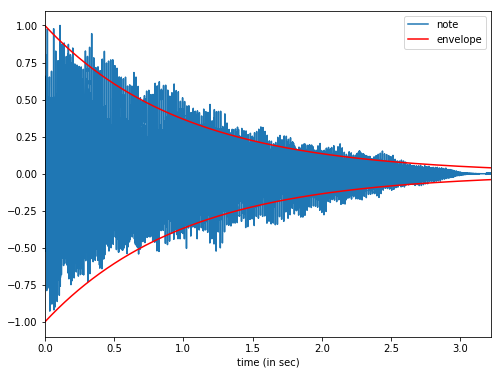

In [14]:
plt.figure(figsize=(8,6))
plt.plot(t_wav,wav,label='note')
plt.plot(t_wav,np.exp(-t_wav),'r',label='envelope')
plt.plot(t_wav,-np.exp(-t_wav),'r')
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.legend(loc='upper right')
plt.show()

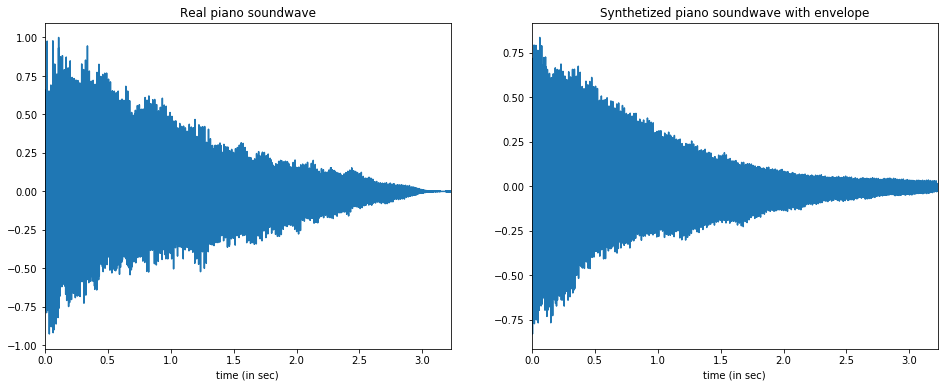

In [15]:
# Let's now apply this envelope to the synthetized soundwave
wav_sup = wav_synth.copy()
wav_inf = wav_synth.copy()
wav_sup[wav_sup<0] = 0
wav_inf[wav_inf>0] = 0
wav_synth_env = wav_sup*np.exp(-t_wav) + wav_inf*(np.exp(-t_wav))

# plot that stuff
plt.figure(figsize=(16,6))
plt.subplots_adjust(hspace=0.5)
plt.subplot(121)
plt.title('Real piano soundwave')
plt.plot(t_wav,wav)
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.subplot(122)
plt.title('Synthetized piano soundwave with envelope')
plt.plot(t_wav,wav_synth_env)
plt.xlim((0,t_wav.max()))
plt.xlabel('time (in sec)')
plt.show()

Close enough, let's save this and see if it sounds like a piano note.

In [16]:
# Let's make the sound stereo
stereo_wav = np.vstack((wav_synth_env,wav_synth_env)).T
sp.io.wavfile.write('synthetized_C2_piano.wav',fs,stereo_wav)

### Bernstein theorem

In its mathematical formulation, Bernstein theorem states that if $x$ is a bandlimited signal with band $B$ (in other words, $|X(\nu)| = 0 \ \forall \ |\nu| \geq B$), then $\displaystyle |x^\prime(t)| \leq 2 \pi B \int_{-B}^B |X(\nu)|d\nu$.  
The exact formulation does not really matters, but this theorem has a nice interpretation being that the maximal variation of $x$ is bounded, and this bound depends on the bandwidth:  
$\rightarrow$ the smaller the bandwidth $B$, the lower the maximal variation of $x$. That should be obvious, since quick variations are represented by high frequencies in the spectrum $X$.  
$\rightarrow$ the larger the bandwidth $B$, the quicker the possible variations of $x$. Well yeah, that's the reversed version of the previous point, so no surprise here.  

Let's empirically check Bernstein theorem.

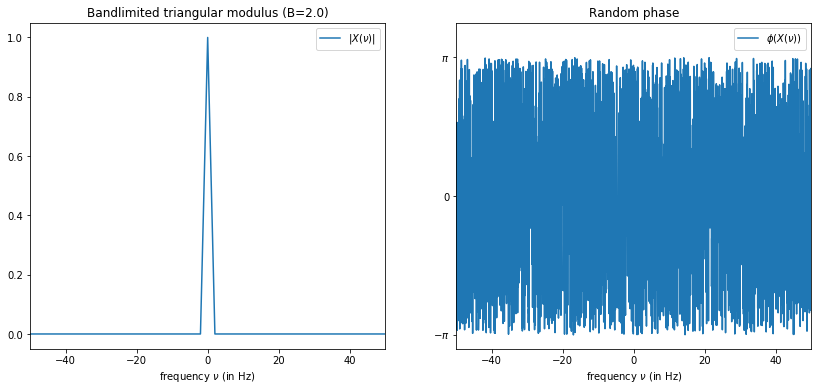

In [54]:
# Create an artifical bandlimited spectrum
nu = sp.fftpack.fftshift(sp.fftpack.fftfreq(t.size))/Tech
bb = 25
B = np.abs(nu.min())/bb
supp_idx = np.abs(nu)<= B
modX = np.zeros(nu.size)

# Spectrum modulus is built asa triangular function
# -------------------------------------------------
modX[supp_idx] = sp.signal.triang(supp_idx.sum())
# Phase of spectrum can be anything (uncomment the proper line)
# ------------------------------------------------------------
# Phase of a Gaussian signal
# phaseX = np.angle(sp.fftpack.fft(sp.stats.norm.pdf(t,scale=1)))
# ttl = 'Phase of a Gaussian function'

# Phase of a Gaussian pulse
# phaseX = np.angle(sp.fftpack.fft(sp.signal.gausspulse((2*t)/t.size)))
# ttl = 'Phase of a Gaussian pulse'

# Phase of a chirp
# phaseX = np.angle(sp.fftpack.fft(sp.signal.chirp(t,0.5,t.max(),0.1)))
# ttl = 'Phase of a chirp'

# Random phase
phaseX = np.random.uniform(-np.pi,np.pi,nu.size)
ttl = 'Random phase'

# plot that stuff
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title('Bandlimited triangular modulus (B=%1.1f)'%B)
plt.plot(nu,modX,label=r'$|X(\nu)|$')
plt.xlim(nu.min(),nu.max())
plt.xlabel(r'frequency $\nu$ (in Hz)')
plt.legend(loc='upper right')
plt.subplot(122)
plt.title(ttl)
plt.plot(nu,phaseX,label=r'$\phi(X(\nu))$')
plt.xlim(nu.min(),nu.max())
plt.xlabel(r'frequency $\nu$ (in Hz)')
plt.ylim(-1.1*np.pi,1.25*np.pi)
plt.yticks([-np.pi,0,np.pi],(r'$-\pi$','0',r'$\pi$'))
plt.legend(loc='upper right')
plt.show()

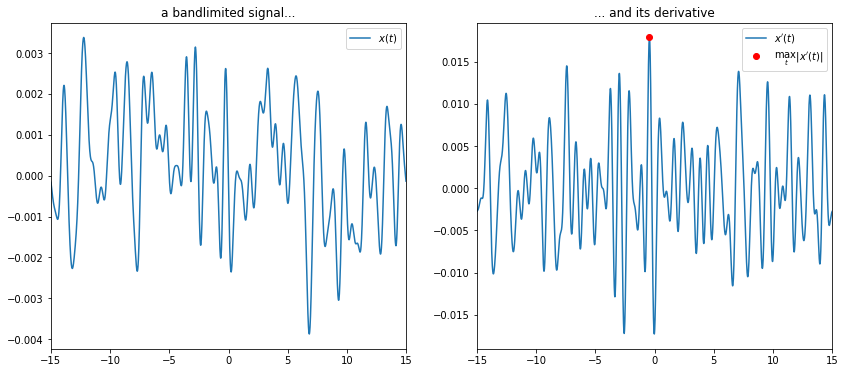

In [55]:
# Invert the Fourier transform to create the bandlimited signal
X = sp.fftpack.ifftshift(modX)*np.exp(1j*phaseX)
x = np.real(sp.fftpack.ifft(X))
# Get the derivative of x
Dx = np.convolve(x, [1,-1],'same')/Tech
tm = np.argmax(np.abs(Dx[1:]))
# Plot that stuff
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title('a bandlimited signal...')
plt.plot(t,x,label=r'$x(t)$')
plt.xlim(t.min(),t.max())
plt.legend(loc='best')
plt.subplot(122)
plt.title('... and its derivative')
plt.plot(t[1:],Dx[1:],label=r'$x^\prime(t)$')
plt.plot(t[tm+1],Dx[tm+1],'ro',label=r'$\max_t |x^\prime(t)|$')
plt.xlim(t.min(),t.max())
plt.legend(loc='best')
plt.show()

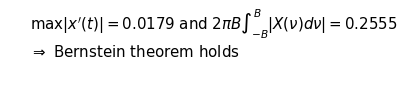

In [56]:
bound_B = 2*np.pi*B*Tech*sp.integrate.trapz(modX,x=nu)
plt.figure(figsize=(1,1))
plt.axis('off')
plt.text(0,1,r'$\max |x^\prime(t)| = %2.4f$ and $2\pi B \int_{-B}^B |X(\nu)d\nu| = %2.4f$'%(np.abs(Dx[1:]).max(),bound_B),
        fontsize=15)
if np.abs(Dx[1:]).max() <= bound_B:
    plt.text(0,0.5,r'$\Rightarrow$ Bernstein theorem holds',fontsize=15)
else:
    plt.text(0,0.5,r"$\Rightarrow$ Hmmm sh*t, that shouldn't happen...",fontsize=15)
plt.show()

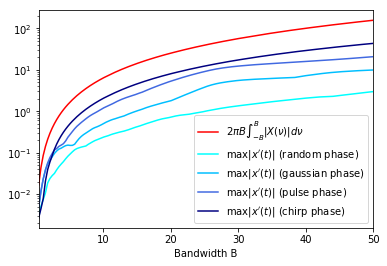

In [57]:
# Let's actually check it for a broad range of bandwidths and different signals at once
bandwidth,max_xprime_rndm,Bernstein_bound = MASI.check_Bernstein_theorem(nu,Tech,np.random.uniform(-np.pi,np.pi,nu.size))
max_xprime_gauss = MASI.check_Bernstein_theorem(nu,Tech,np.angle(sp.fftpack.fft(sp.stats.norm.pdf(t,scale=1))))[1]
max_xprime_gausspulse = MASI.check_Bernstein_theorem(nu,Tech,np.angle(sp.fftpack.fft(sp.signal.gausspulse((2*t)/t.size))))[1]
max_xprime_chirp = MASI.check_Bernstein_theorem(nu,Tech,np.angle(sp.fftpack.fft(sp.signal.chirp(t,0.5,t.max(),0.1))))[1]
# and now, plot all that stuff
plt.plot(bandwidth,Bernstein_bound,'r',label=r'$2\pi B \int_{-B}^B |X(\nu)|d\nu$')
plt.plot(bandwidth,max_xprime_rndm,c='cyan',label=r'$\max |x^\prime(t)|$ (random phase)')
plt.plot(bandwidth,max_xprime_gauss,c='deepskyblue',label=r'$\max |x^\prime(t)|$ (gaussian phase)')
plt.plot(bandwidth,max_xprime_gausspulse,c='royalblue',label=r'$\max |x^\prime(t)|$ (pulse phase)')
plt.plot(bandwidth,max_xprime_chirp,c='navy',label=r'$\max |x^\prime(t)|$ (chirp phase)')
plt.xlim(bandwidth.min(),bandwidth.max())
plt.xlabel('Bandwidth B')
plt.yscale('log')
plt.legend(loc='bottom left')
plt.show()

So, Bernstein theorem holds. Good.